In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import re   
import importlib
# Load the questionnaire data
questionnaire_df = pd.read_excel('data/questionnaire_data-561422-2025-11-17-1240.xlsx')

/home/michaelt/.cache/pypoetry/virtualenvs/in9060-as2-Pf7P2CoS-py3.12/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [8]:
# Rename questionnaire_df columns to concise snake_case with condition suffixes


# Mapping from full question text to short code
_base_map = {
    'Participant number': 'participant_id',
    'What is your gender': 'gender',
    'How old are you?': 'age',
    'What is your dominant hand?': 'dominant_hand',
    'How experienced are you with robotic systems?': 'robotics_experience',
    'Did you experience delays between your actions and the robot\'s movements?': 'delay',
    'How difficult was it to perform the task?': 'difficulty',
    'I felt like I was controlling the movement of the robot': 'control',
    'It felt like the robot was part of my body': 'body'
}

repeating_keys = {'delay','difficulty','control','body'}
rename_map = {}
for col in questionnaire_df.columns:
    if col.startswith('$'):  # keep metadata columns unchanged
        continue
    # Remove HTML entity artifacts
    col_clean = col.replace('&#39;', "'")
    # Extract suffix like .1, .2, etc.
    m = re.search(r'\.(\d+)$', col_clean)
    base = re.sub(r'\.(\d+)$', '', col_clean)
    short = _base_map.get(base, None)
    if short is None:
        # If unknown and not metadata, create a generic snake_case key
        generic = re.sub(r'[^A-Za-z0-9]+', '_', base).strip('_').lower()
        short = generic or base.lower()
    if m:
        suffix = f"_{m.group(1)}"  # condition index from original numbering
    elif short in repeating_keys:
        suffix = "_0"  # first occurrence without explicit suffix
    else:
        suffix = ""
    rename_map[col] = short + suffix

questionnaire_df = questionnaire_df.rename(columns=rename_map)

print('Renamed columns (first 25):')
print(list(questionnaire_df.columns)[:25])

# Filter out columns containing "$"
filtered_columns = [col for col in questionnaire_df.columns if '$' not in col and col != 'Participant number']
print('Filtered columns (first 25):')
print(filtered_columns[:25])

participant_data_columns = filtered_columns[0:4]
task_one_columns = filtered_columns[5:25]
task_two_columns = filtered_columns[25:]


participant_df = questionnaire_df[participant_data_columns]
task_one_df = questionnaire_df[task_one_columns]
task_two_df = questionnaire_df[task_two_columns]
all_tasks_df = task_one_df + task_two_df
all_tasks_concat = pd.concat([task_one_df, task_two_df], ignore_index=True)


print('Filtered columns (first 25):')
# print(list(task_one_df.columns)[:25])
print(list(task_two_df.columns)[:25])

metric_mask_delay = [col for col in all_tasks_df.columns if col.startswith('delay_')]
metric_mask_difficulty = [col for col in all_tasks_df.columns if col.startswith('difficulty_')]
metric_mask_control = [col for col in all_tasks_df.columns if col.startswith('control_')]
metric_mask_body = [col for col in all_tasks_df.columns if col.startswith('body_')]

# Filter task_one_df for male participants
male_mask = participant_df['gender'] == 'Male'
female_mask = participant_df['gender'] == 'Female'
Other_mask = participant_df['gender'] == 'Other'
task_two_male_df = task_two_df[male_mask]
task_two_female_df = task_two_df[female_mask]

# Age mask and arrays
# Calculate median age
median_age = participant_df['age'].median()
age_mask_A24 = participant_df['age'] > median_age
age_mask_U24 = participant_df['age'] <= median_age

# Select from task_one_df where both male_mask and age_mask_A24 are true
task_two_M_A24 = task_two_df[male_mask & age_mask_A24]
task_two_M_U24 = task_two_df[male_mask & age_mask_U24]
task_two_F_A24 = task_two_df[female_mask & age_mask_A24]
task_two_F_U24 = task_two_df[female_mask & age_mask_U24]


Renamed columns (first 25):
['$submission_id', '$created', 'participant_id', 'gender', 'age', 'dominant_hand', 'robotics_experience', 'delay_0', 'difficulty_0', 'control_0', 'body_0', 'delay_1', 'difficulty_1', 'control_1', 'body_1', 'delay_2', 'difficulty_2', 'control_2', 'body_2', 'delay_3', 'difficulty_3', 'control_3', 'body_3', 'delay_4', 'difficulty_4']
Filtered columns (first 25):
['participant_id', 'gender', 'age', 'dominant_hand', 'robotics_experience', 'delay_0', 'difficulty_0', 'control_0', 'body_0', 'delay_1', 'difficulty_1', 'control_1', 'body_1', 'delay_2', 'difficulty_2', 'control_2', 'body_2', 'delay_3', 'difficulty_3', 'control_3', 'body_3', 'delay_4', 'difficulty_4', 'control_4', 'body_4']
Filtered columns (first 25):
['delay_5', 'difficulty_5', 'control_5', 'body_5', 'delay_6', 'difficulty_6', 'control_6', 'body_6', 'delay_7', 'difficulty_7', 'control_7', 'body_7', 'delay_8', 'difficulty_8', 'control_8', 'body_8', 'delay_9', 'difficulty_9', 'control_9', 'body_9']


In [9]:
# Difficulty for Male-Female
task_two_difficulty_df = all_tasks_concat[[col for col in all_tasks_concat.columns if col.startswith('difficulty_')]]
task_two_difficulty_df_male = task_two_difficulty_df[male_mask]
task_two_difficulty_df_female = task_two_difficulty_df[female_mask]

task_two_stats_male = pd.DataFrame({
    'Mean': task_two_difficulty_df_male.mean(numeric_only=True),
    'Variance': task_two_difficulty_df_male.var(numeric_only=True)
})
task_two_stats_female = pd.DataFrame({
    'Mean': task_two_difficulty_df_female.mean(numeric_only=True),
    'Variance': task_two_difficulty_df_female.var(numeric_only=True)
})

print("Task One Statistics Male:")
print(task_two_stats_male)
print("\nTask One Statistics Female:")
print(task_two_stats_female)

/tmp/ipykernel_39384/1222104069.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_two_difficulty_df_male = task_two_difficulty_df[male_mask]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [7]:
# Difficulty for MF and Age 
# task_two_difficulty_df = task_two_df[[col for col in task_two_df.columns if col.startswith('difficulty_')]]
task_two_difficulty_df = all_tasks_concat[[col for col in all_tasks_concat.columns if col.startswith('difficulty_')]]
task_two_difficulty_df_male = task_two_difficulty_df[male_mask]
task_two_difficulty_df_female = task_two_difficulty_df[female_mask]

task_two_difficulty_M_A24 = task_two_difficulty_df[male_mask & age_mask_A24]
task_two_difficulty_M_U24 = task_two_difficulty_df[male_mask & age_mask_U24]
task_two_difficulty_F_A24 = task_two_difficulty_df[female_mask & age_mask_A24]
task_two_difficulty_F_U24 = task_two_difficulty_df[female_mask & age_mask_U24]

task_two_stats_male_A24 = pd.DataFrame({
    'Mean': task_two_difficulty_M_A24.mean(numeric_only=True),
    'Variance': task_two_difficulty_M_A24.var(numeric_only=True)
})
task_two_stats_female_A24 = pd.DataFrame({
    'Mean': task_two_difficulty_F_A24.mean(numeric_only=True),
    'Variance': task_two_difficulty_F_A24.var(numeric_only=True)
})
task_two_stats_male_U24 = pd.DataFrame({
    'Mean': task_two_difficulty_M_U24.mean(numeric_only=True),
    'Variance': task_two_difficulty_M_U24.var(numeric_only=True)
})
task_two_stats_female_U24 = pd.DataFrame({
    'Mean': task_two_difficulty_F_U24.mean(numeric_only=True),
    'Variance': task_two_difficulty_F_U24.var(numeric_only=True)
})

print("Task One Statistics Male:")
print(task_two_stats_male_A24)
print("\nTask One Statistics Female:")
print(task_two_stats_female_A24)

/tmp/ipykernel_39384/3578424156.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  task_two_difficulty_df_male = task_two_difficulty_df[male_mask]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [5]:
task_two_difficulty_df_male.shape[0]
task_two_difficulty_df_male.shape[1]

5

In [6]:
# Basic Single iteration

import alt_statistics as alt_vp
# importlib.reload(alt_vp)
all_variance_stats = alt_vp.calculate_statistics(
    distributions=[
        # task_one_difficulty_df_male["difficulty_0"], task_one_difficulty_df_female["difficulty_0"]
        task_two_difficulty_df_male, task_two_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population','alt_ssa', 'alt_ftest'],
    # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    # output_csv='comprehensive_stats_delay_overall.csv'
    output_csv='out_csv/difficulty MF/difficulty_T2_MF_overall.csv'
)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))



Statistics saved to: out_csv/difficulty MF/difficulty_T2_MF_overall.csv

Comprehensive Statistics - All Variance Types
  Group Subgroup   N     Mean   SAMPLE  POPULATION  ALT_SSA    ALT_FTEST
   Male  Group_1  24 2.291667 0.998188    0.956597 0.172601 3.631888e-04
   Male  Group_1  24 2.375000 1.114130    1.067708 0.000052 9.784963e-08
   Male  Group_1  24 2.416667 1.036232    0.993056 0.038777 7.860017e-05
   Male  Group_1  24 2.416667 1.297101    1.243056 0.038777 6.279231e-05
   Male  Group_1  24 2.083333 0.862319    0.826389 2.062307 5.023278e-03
 Female  Group_2  10 2.500000 0.722222    0.650000 0.152595 2.898294e-03
 Female  Group_2  10 2.300000 0.677778    0.610000 0.058478 1.183516e-03
 Female  Group_2  10 2.700000 1.344444    1.210000 1.046713 1.067965e-02
 Female  Group_2  10 2.600000 0.711111    0.640000 0.499654 9.638387e-03
 Female  Group_2  10 2.500000 0.944444    0.850000 0.152595 2.216342e-03
Overall      all 170 2.376471 0.981692    0.975917 0.000000 0.000000e+00


In [7]:
# For the MF age

import alt_statistics as alt_vp
# importlib.reload(alt_vp)
all_variance_stats = alt_vp.calculate_statistics(
    distributions=[
        # task_one_difficulty_df_male["difficulty_0"], task_one_difficulty_df_female["difficulty_0"]
        task_two_difficulty_M_A24, 
        task_two_difficulty_F_A24,
        task_two_difficulty_M_U24, 
        task_two_difficulty_F_U24
    ],
    # group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population','alt_ssa', 'alt_ftest'],
    # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
    # output_csv='comprehensive_stats_delay_overall.csv'
    output_csv='out_csv/difficulty MF/difficulty_T2_MF-AGE_overall.csv'
)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Statistics saved to: out_csv/difficulty MF/difficulty_T2_MF-AGE_overall.csv

Comprehensive Statistics - All Variance Types
  Group Subgroup   N     Mean   SAMPLE  POPULATION  ALT_SSA  ALT_FTEST
Group_1  Group_1   5 2.200000 0.700000    0.560000 0.155709   0.014634
Group_1  Group_1   5 1.800000 0.200000    0.160000 1.661592   0.546576
Group_1  Group_1   5 2.600000 2.300000    1.840000 0.249827   0.007146
Group_1  Group_1   5 1.800000 1.700000    1.360000 1.661592   0.064303
Group_1  Group_1   5 2.200000 0.200000    0.160000 0.155709   0.051220
Group_2  Group_2   6 2.500000 1.100000    0.916667 0.091557   0.003505
Group_2  Group_2   6 2.166667 0.566667    0.472222 0.264106   0.019624
Group_2  Group_2   6 3.000000 1.200000    1.000000 2.332734   0.081850
Group_2  Group_2   6 3.000000 0.400000    0.333333 2.332734   0.245551
Group_2  Group_2   6 2.833333 0.966667    0.805556 1.252341   0.054548
Group_3  Group_3  19 2.315789 1.116959    1.058172 0.069962   0.000203
Group_3  Group_3  19 2.52

# Ok I think this is the one
In the language of the slides:
the ***measurments*** are the individual responses
and the ***alternatives*** is the m/F classes

in stats one I do the m/f classes so only two alternatives

in stats two I will attempt to divide into age groups

## Stats One

In [8]:
import alt_statistics as alt_vp
# importlib.reload(alt_vp)
# Iterate over array columns in each dataframe
# Compare each column of task_one_difficulty_df_male against the respective column in task_one_difficulty_df_female
# and then concatenate results into a single dataframe and csv

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_two_difficulty_df_male.columns:
    if col in task_two_difficulty_df_female.columns:
        # Calculate statistics for this column pair
        stats_df = alt_vp.calculate_statistics(
            distributions=[
                task_two_difficulty_df_male[[col]], 
                task_two_difficulty_df_female[[col]]
            ],
            group_labels=['Male', 'Female'],
            # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
            variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
            output_csv=None  # Don't output individual CSVs
        )
        
        # Add column name to the stats dataframe
        stats_df.insert(0, 'Column', col)
        all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_two_difficulty_df_male, 
        task_two_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF/difficulty_T2_MF_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Comprehensive Statistics - All Variance Types
      Column   Group Subgroup   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA  ALT_SSA    ALT_FTEST
difficulty_5    Male  Group_1  24 2.291667 0.998188    0.956597 0.999094 0.956597  22.958333 0.041591  23.048443  22.958333 0.090110 0.090110 3.412972e-04
difficulty_5  Female  Group_2  10 2.500000 0.722222    0.650000 0.849837 0.650000   6.500000 0.072222   6.716263   6.500000 0.216263 0.216263 7.393606e-03
difficulty_5 Overall      all  34 2.352941 0.901961    0.875433 0.949716 0.875433  29.764706 0.026528  29.764706  29.764706 0.000000 0.000000 0.000000e+00
difficulty_6    Male  Group_1  24 2.375000 1.114130    1.067708 1.055524 1.067708  25.625000 0.046422  25.636678  25.625000 0.011678 0.011678 3.962910e-05
difficulty_6  Female  Group_2  10 2.300000 0.677778    0.610000 0.823273 0.610000   6.100000 0.067778   6.128028   6.100000 0.028028 0.028028 1.021045e-03
difficulty_6 Overall   

## Stats Two

In [9]:
# Stats TWO

# import alt_statistics as alt_vp
# importlib.reload(alt_vp)
# Iterate over array columns in each dataframe
# Compare each column of task_one_difficulty_df_male against the respective column in task_one_difficulty_df_female
# and then concatenate results into a single dataframe and csv

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_two_difficulty_df_male.columns:
    if col in task_two_difficulty_df_female.columns:
        # Calculate statistics for this column pair
        stats_df = alt_vp.calculate_statistics(
            distributions=[
                task_two_difficulty_df_male[[col]], 
                task_two_difficulty_df_female[[col]]
            ],
            group_labels=['Male', 'Female'],
            # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
            variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
            output_csv=None  # Don't output individual CSVs
        )
        
        # Add column name to the stats dataframe
        stats_df.insert(0, 'Column', col)
        all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_two_difficulty_df_male, 
        task_two_difficulty_df_female
    ],
    group_labels=['Male', 'Female'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF/difficulty_T2_MF_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Comprehensive Statistics - All Variance Types
      Column   Group Subgroup   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA  ALT_SSA    ALT_FTEST
difficulty_5    Male  Group_1  24 2.291667 0.998188    0.956597 0.999094 0.956597  22.958333 0.041591  23.048443  22.958333 0.090110 0.090110 3.412972e-04
difficulty_5  Female  Group_2  10 2.500000 0.722222    0.650000 0.849837 0.650000   6.500000 0.072222   6.716263   6.500000 0.216263 0.216263 7.393606e-03
difficulty_5 Overall      all  34 2.352941 0.901961    0.875433 0.949716 0.875433  29.764706 0.026528  29.764706  29.764706 0.000000 0.000000 0.000000e+00
difficulty_6    Male  Group_1  24 2.375000 1.114130    1.067708 1.055524 1.067708  25.625000 0.046422  25.636678  25.625000 0.011678 0.011678 3.962910e-05
difficulty_6  Female  Group_2  10 2.300000 0.677778    0.610000 0.823273 0.610000   6.100000 0.067778   6.128028   6.100000 0.028028 0.028028 1.021045e-03
difficulty_6 Overall   

## Stats Three
Populations according to my stats:
M_A24 5,
F_A24 6,
M_U24 19
F_U24 4

In [10]:
# Stats -MF Age groups
importlib.reload(alt_vp)

pick_variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],

all_stats_list = []

for col in task_two_difficulty_M_A24.columns:
    if col in task_two_difficulty_F_A24.columns:
        if col in task_two_difficulty_M_U24.columns:
            if col in task_two_difficulty_F_U24.columns:
                # Calculate statistics for this column pair
                stats_df = alt_vp.calculate_statistics(
                    distributions=[
                        task_two_difficulty_M_A24[[col]], 
                        task_two_difficulty_F_A24[[col]],
                        task_two_difficulty_M_U24[[col]], 
                        task_two_difficulty_F_U24[[col]]
                    ],
                    # group_labels=['Male_A24', 'Female_A24','Male_U24', 'Female_U24'],
                    group_labels=['Male', 'Female', 'Male', 'Female'],
                    subgroup_labels=[ 'A24','A24', 'U24', 'U24'],
                    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
                    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
                    output_csv=None  # Don't output individual CSVs
                )
                
                # Add column name to the stats dataframe
                stats_df.insert(0, 'Column', col)
                all_stats_list.append(stats_df)

stats_df = alt_vp.calculate_statistics(
    distributions=[
        task_two_difficulty_M_A24,
        task_two_difficulty_F_A24,
        task_two_difficulty_M_U24,
        task_two_difficulty_F_U24
    ],
    group_labels=['Male_A24', 'Female_A24','Male_U24', 'Female_U24'],
    # variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest', 'old_ftest'],
    variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'alt_ssa', 'alt_ftest'],
    output_csv=None  # Don't output individual CSVs
    )
# Add column name to the stats dataframe
stats_df.insert(0, 'Column', 'ALL')
all_stats_list.append(stats_df)

# Concatenate all results
all_variance_stats = pd.concat(all_stats_list, ignore_index=True)

# Output to CSV
all_variance_stats.to_csv('out_csv/difficulty MF/difficulty_T2_MF-AGE_overall.csv', index=False)

print("\nComprehensive Statistics - All Variance Types")
print("=" * 140)
print(all_variance_stats.to_string(index=False))




Comprehensive Statistics - All Variance Types
      Column      Group Subgroup   N     Mean   SAMPLE  POPULATION      STD      MSE         SS    TUKEY        SST        SSE      SSA  ALT_SSA  ALT_FTEST
difficulty_5       Male      A24   5 2.200000 0.700000    0.560000 0.836660 0.560000   2.800000 0.140000   2.916955   2.800000 0.116955 0.116955   0.013923
difficulty_5     Female      A24   6 2.500000 1.100000    0.916667 1.048809 0.916667   5.500000 0.183333   5.629758   5.500000 0.129758 0.129758   0.006291
difficulty_5       Male      U24  19 2.315789 1.116959    1.058172 1.056863 1.058172  20.105263 0.058787  20.131488  20.105263 0.026225 0.026225   0.000097
difficulty_5     Female      U24   4 2.500000 0.333333    0.250000 0.577350 0.250000   1.000000 0.083333   1.086505   1.000000 0.086505 0.086505   0.038447
difficulty_5    Overall      all  34 2.352941 0.901961    0.875433 0.949716 0.875433  29.764706 0.026528  29.764706  29.764706 0.000000 0.000000   0.000000
difficulty_6     

## Something from before idk

In [11]:
# Example 3: Comprehensive statistics with all variance types
# Calculate and display statistics in a table
# import fig.variance_plot as vp
# # importlib.reload(vp)
# all_variance_stats = vp.calculate_statistics(
#     distributions=[
#         task_two_difficulty_df_male, task_two_difficulty_df_female
#     ],
#     group_labels=['Male', 'Female'],
#     variance_types=['sample', 'population', 'std', 'mse', 'ss', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
#     # variance_types=['sample', 'mse', 'tukey', 'sst', 'sse', 'ssa', 'ftest'],
#     # output_csv='comprehensive_stats_delay_overall.csv'
# )

# print("\nComprehensive Statistics - All Variance Types")
# print("=" * 140)
# print(all_variance_stats.to_string(index=False))

# print("\n\nColumn Descriptions:")
# print("-" * 140)
# print("N         : Sample size")
# print("Mean      : Arithmetic mean")
# print("SAMPLE    : Sample variance (ddof=1, unbiased estimator)")
# print("POPULATION: Population variance (ddof=0)")
# print("STD       : Standard deviation (ddof=1)")
# print("MSE       : Mean Squared Error from mean")
# print("SS        : Sum of Squares (within group)")
# print("TUKEY     : Tukey's HSD variance estimate (variance/n)")
# print("SST       : Total Sum of Squares (from grand mean)")
# print("SSE       : Error/Within Sum of Squares (from group means)")
# print("SSA       : Among/Between Groups Sum of Squares")
# print("FTEST     : F-test component (within-group variance)")


# Plots


difficulty_5


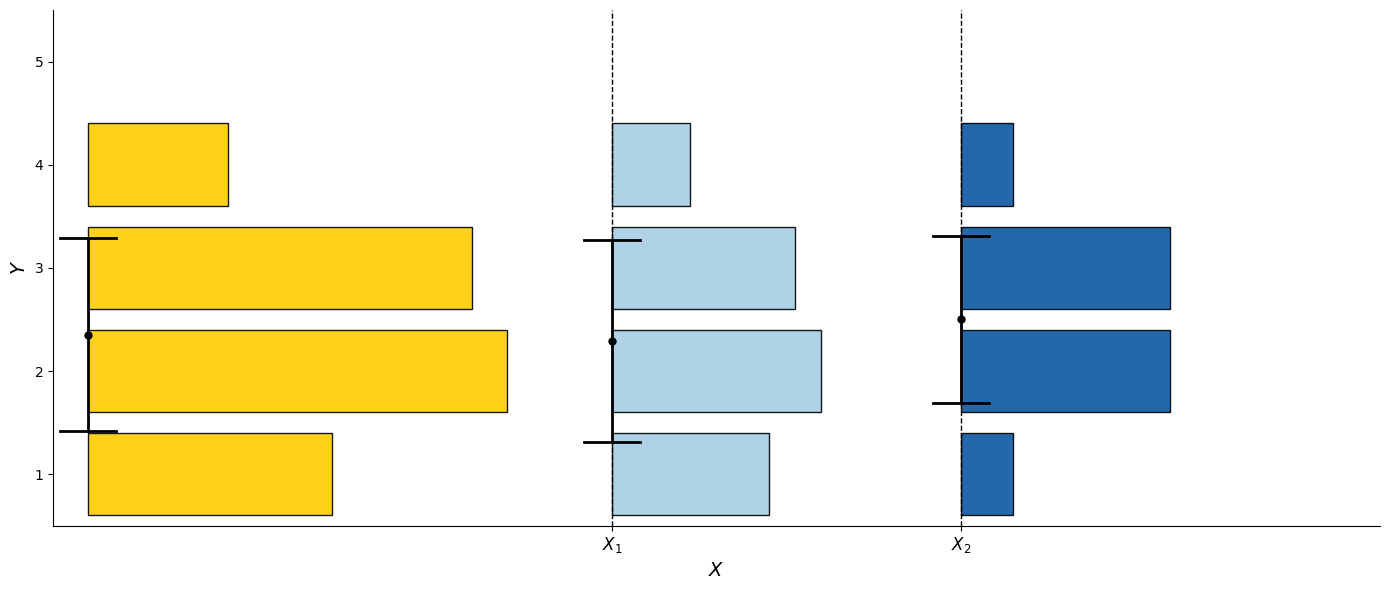

difficulty_6


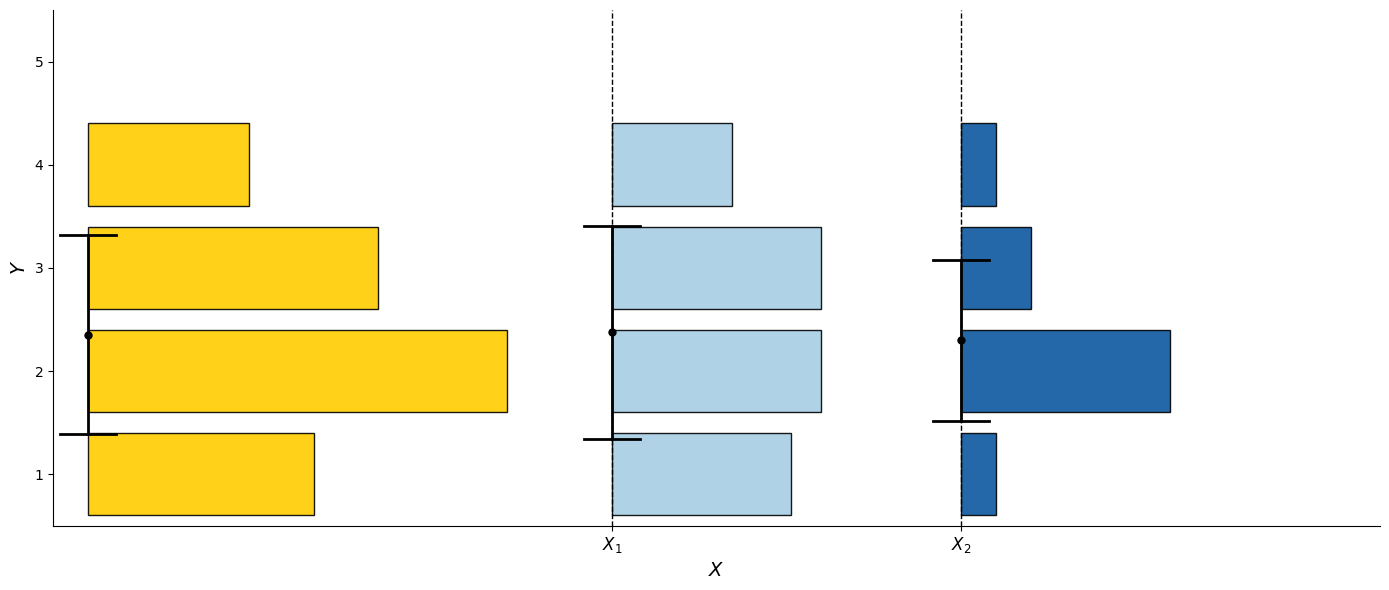

difficulty_7


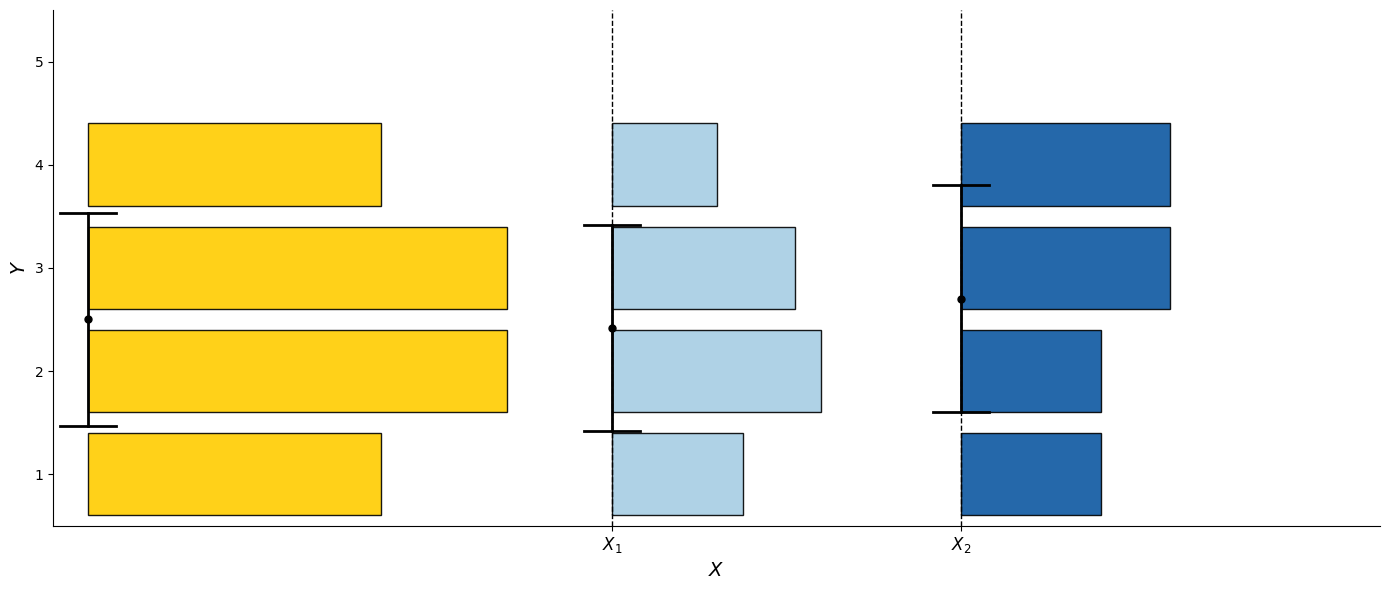

difficulty_8


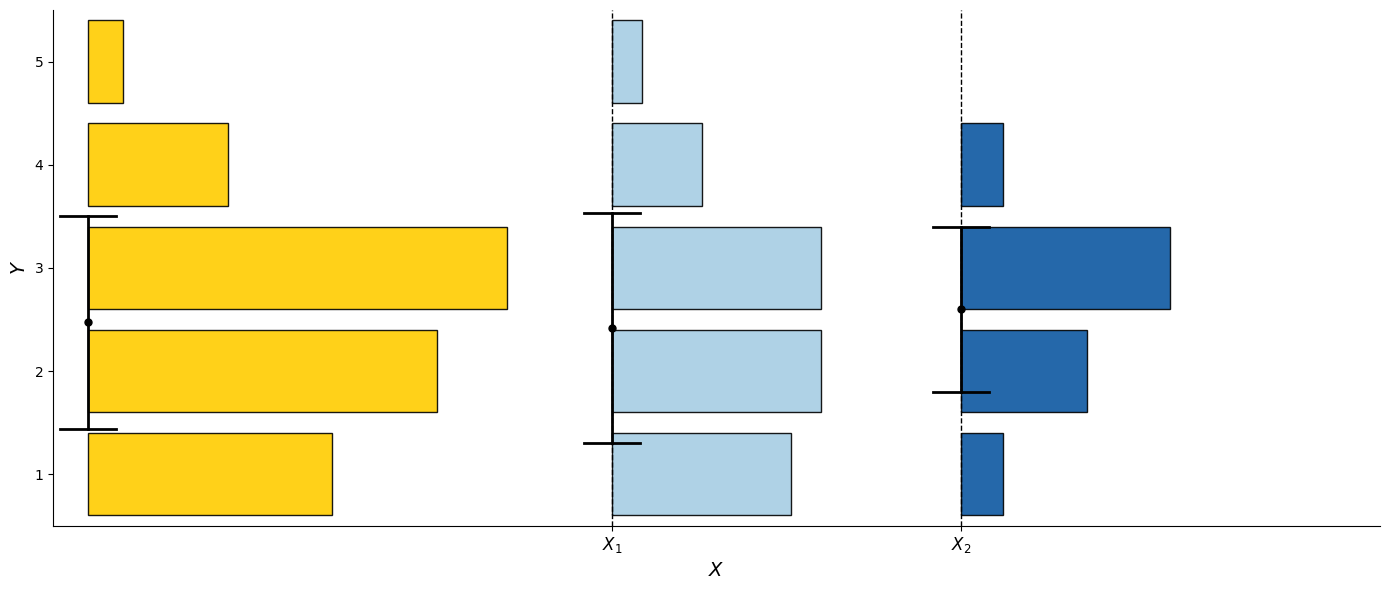

difficulty_9


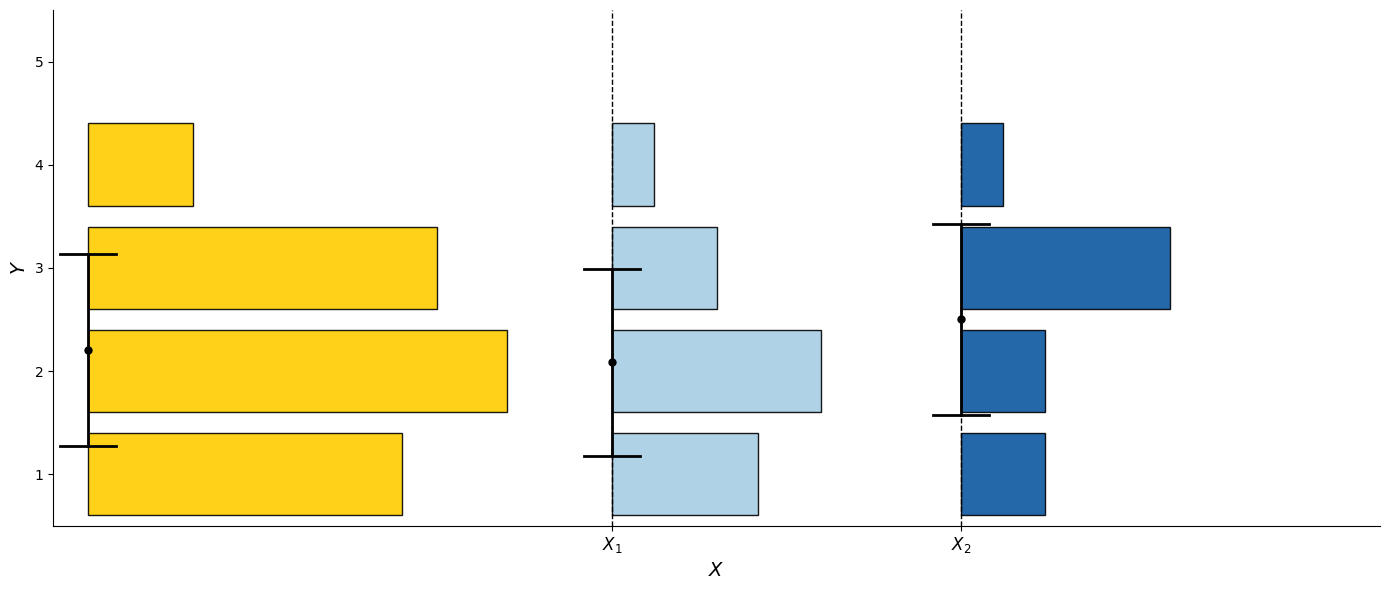

In [12]:
import fig.variance_plot as vpd
for col in task_two_difficulty_df_male.columns:
    if col in task_two_difficulty_df_female.columns:
        distributions=[
            task_two_difficulty_df_male[[col]], 
            task_two_difficulty_df_female[[col]]
        ],
        print(col)
        fig2, ax2 = vpd.variance_decomposition_plot([
            task_two_difficulty_df_male[[col]], 
            task_two_difficulty_df_female[[col]]
        ],
        y_max=5.5,
        variance_type='mse',
        show_dotted_lines=False,
        show_y_annotations=False,
        # figsize=(8, 6)
        bandwidth_adjust=0.5)
        plt.savefig(f'out_csv/difficulty MF/T2_{col}_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
        

difficulty_5


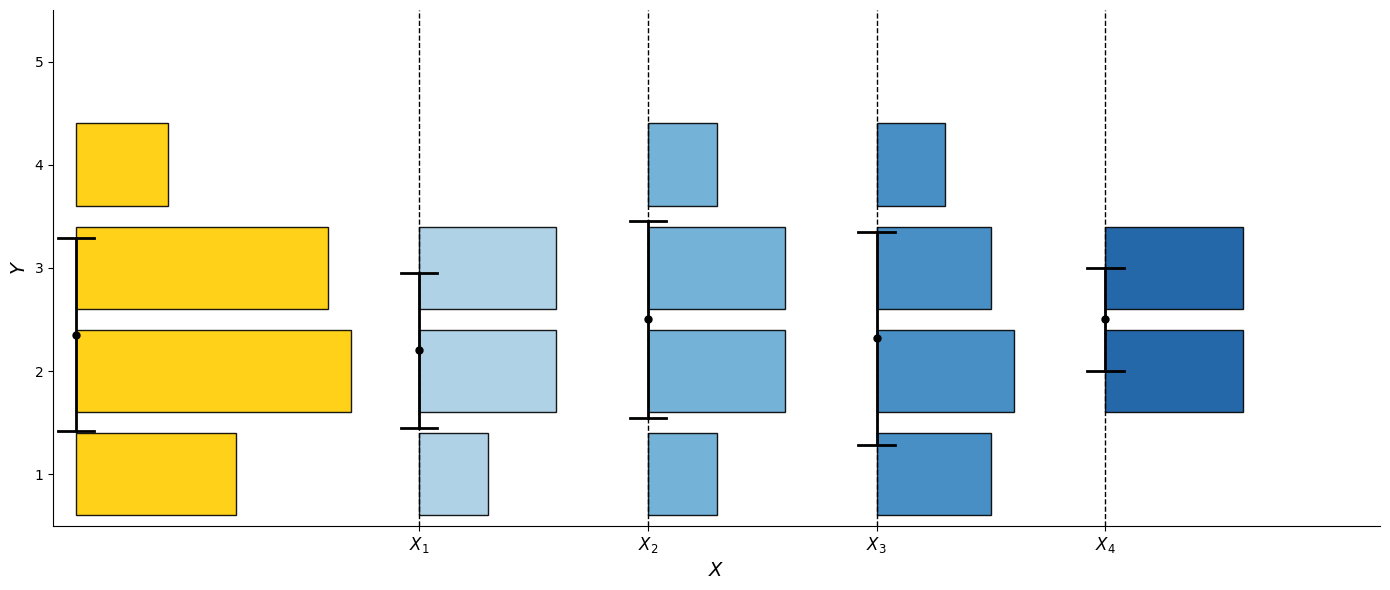

difficulty_6


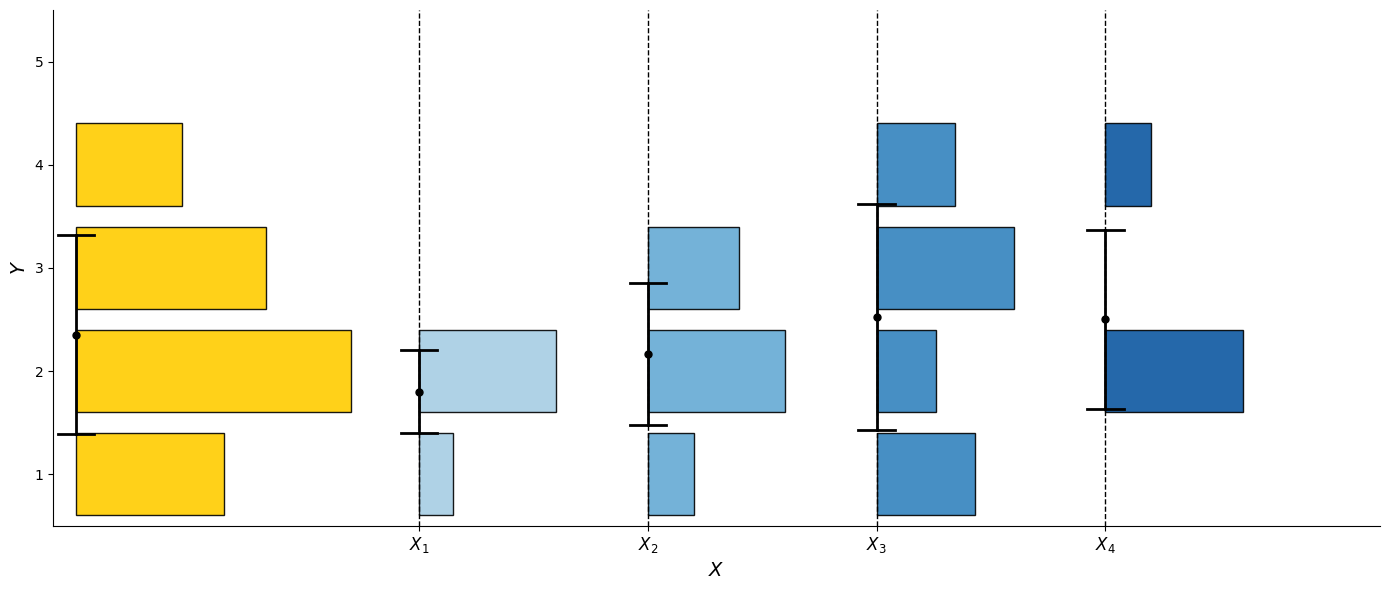

difficulty_7


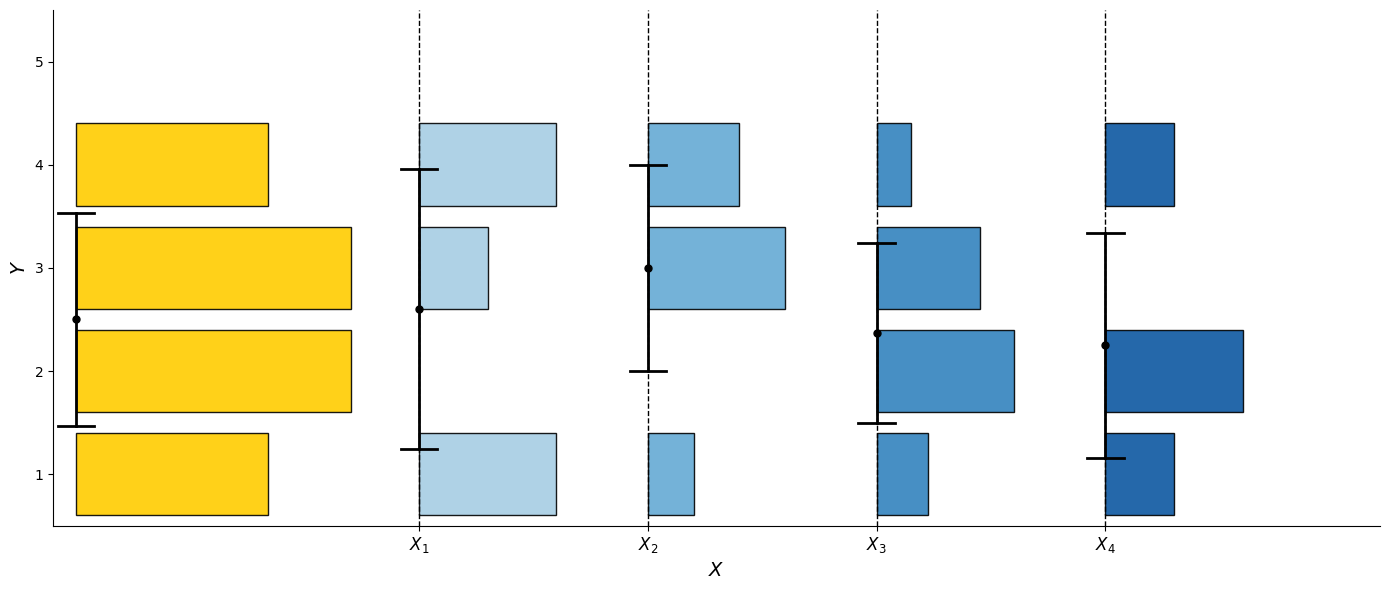

difficulty_8


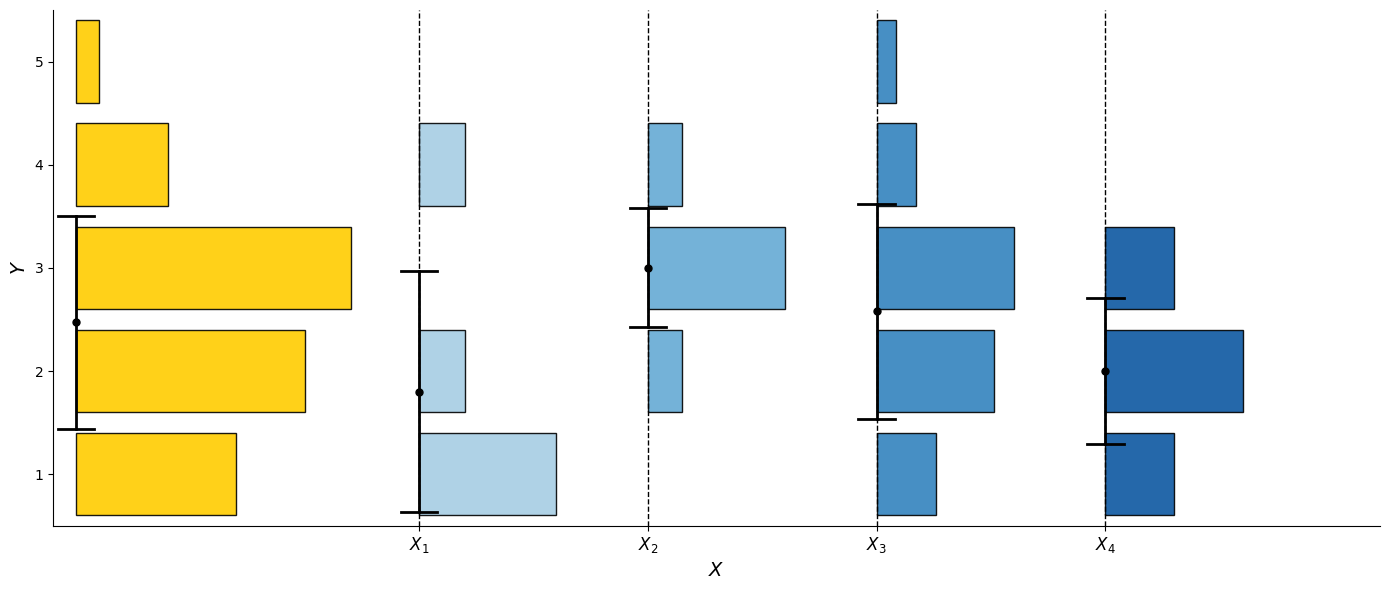

difficulty_9


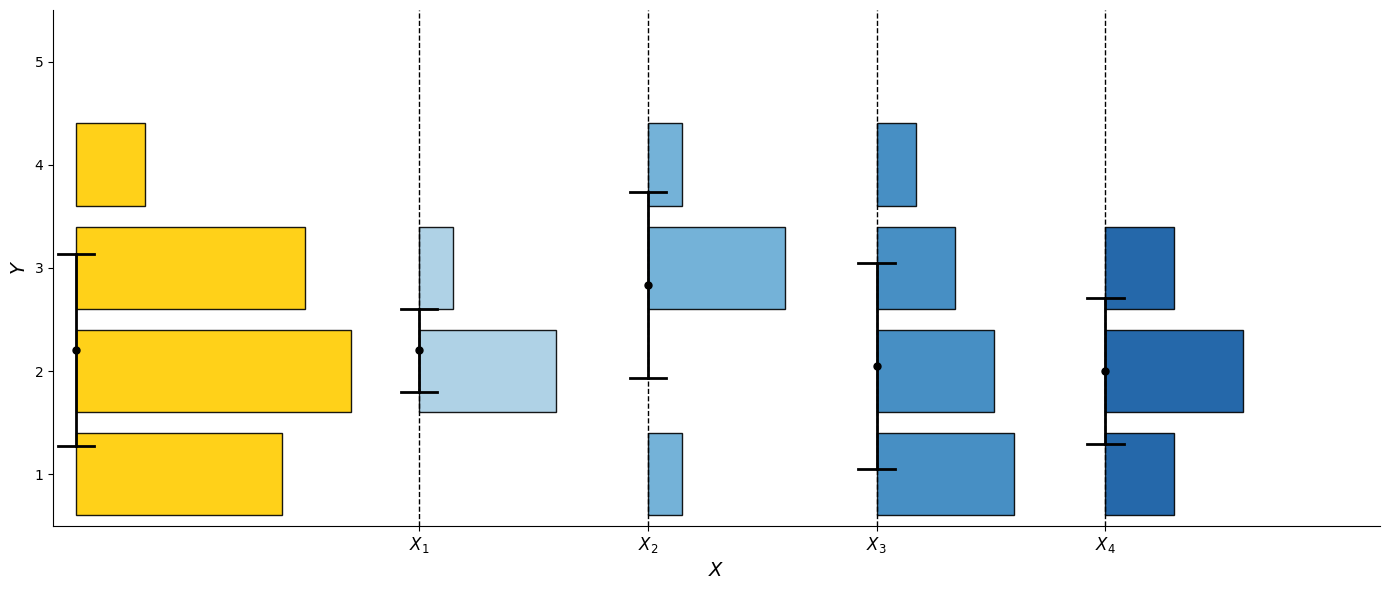

In [13]:
import fig.variance_plot as vpd
for col in task_two_difficulty_M_A24.columns:
    if col in task_two_difficulty_F_A24.columns:
        if col in task_two_difficulty_M_U24.columns:
            if col in task_two_difficulty_F_U24.columns:
                # Calculate statistics for this column pair
                # stats_df = alt_vp.calculate_statistics(
                distributions=[
                    task_two_difficulty_M_A24[[col]], 
                    task_two_difficulty_F_A24[[col]],
                    task_two_difficulty_M_U24[[col]], 
                    task_two_difficulty_F_U24[[col]]
                ]
                # distributions=[
                #     task_one_difficulty_df_male[[col]], 
                #     task_one_difficulty_df_female[[col]]
                # ],
                print(col)
                fig2, ax2 = vpd.variance_decomposition_plot(distributions,
                y_max=5.5,
                variance_type='mse',
                show_dotted_lines=False,
                show_y_annotations=False,
                # figsize=(8, 6)
                bandwidth_adjust=0.5)
                plt.savefig(f'out_csv/difficulty MF-AGE/T2_{col}_plot.png', dpi=300, bbox_inches='tight')
                plt.show()
